## 数据说明

这里使用的数据是olr的日平均数据：https://www.psl.noaa.gov/data/gridded/data.interp_OLR.html

选择处理的时间为:1980-1999,纬度范围为25S-25N

代码中用到的关于ncl的测试数据链接在：

https://density.lanzouu.com/b0ko1sn0h
密码:9xhs

In [3]:
import numpy as np
from scipy.fft import fft2, ifft2
from math import pi, acos, sqrt
from scipy import signal, fft
import xarray as xr
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import sys
import matplotlib
import scipy
print(f"Running Python {sys.version}\n")
print(f"numpy version: {np.__version__}")
print(f"xarray version: {xr.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"matplotlib version: {matplotlib.__version__}\n")
# ================================================================================================
# Author: %(Jianpu)s | Affiliation: Hohai
# email : xianpuji@hhu.edu.cn
# =================================================================================================

Running Python 3.9.22 | packaged by conda-forge | (main, Apr 14 2025, 23:26:18) [MSC v.1929 64 bit (AMD64)]

numpy version: 2.0.2
xarray version: 2024.7.0
scipy version: 1.13.1
matplotlib version: 3.9.4



## 定义平滑函数，用来平滑气候态

In [ ]:
def extract_low_harmonics(data: xr.DataArray, n_harm: int = 3, dim: str = 'dayofyear') -> xr.DataArray:
    """
    从逐日气候态中提取指定阶数的谐波并重构信号。

    参数：
    - data: 输入的xarray.DataArray（时间维度应为dayofyear的气候态）。
    - n_harm: 要保留的最高谐波阶数（保留 0~n_harm-1 的谐波，第 n_harm 的系数减半）。
    - dim: 要进行 FFT 的维度（默认是 'dayofyear'）。

    返回：
    - 仅包含低阶谐波的重建数据，类型为 xarray.DataArray。
    """
    # 傅里叶变换
    z_fft = np.fft.rfft(data, axis=data.get_axis_num(dim))
    
    # 设置频率
    # freqs = np.fft.rfftfreq(data.sizes[dim])
    
    # 保留低阶谐波并处理第 n_harm 阶的振幅
    z_fft_n = z_fft.copy()
    z_fft_n[n_harm,:,:] *= 0.5  # 第 n_harm 阶振幅减半
    z_fft_n[(n_harm+1):,:,:] = 0
  
    # 反傅里叶变换，保留实数部分
    clim_low_harm = np.fft.irfft(z_fft_n, n=data.sizes[dim], axis=data.get_axis_num(dim)).real
    
    # 保持 xarray 格式和原数据一致
    coords = {k: v for k, v in data.coords.items()}
    dims = data.dims
    attrs = {
        "smoothing"     : f"FFT: {n_harm} harmonics were retained.",
        "information"   : "Smoothed daily climatological averages",
        "units"         : "W/m^2",
        "long_name"     : "Daily Climatology: Daily Mean OLR",
    }
    
    return xr.DataArray(clim_low_harm, coords=coords, dims=dims, attrs=attrs)

## 定义主要滤波函数

In [60]:
def  kf_filter_optimized(in_data: xr.DataArray, lon: np.ndarray, obs_per_day: int, t_min: float, t_max: float, k_min: float, k_max: float, h_min: float, h_max: float, wave_name: str) -> xr.DataArray:
    """
    Apply WK99 Kelvin wave filter to 3D time-lat-longitude data.
    
    Parameters:
        in_data: xarray.DataArray with dims ("time", "lat", "lon")
        obs_per_day: time resolution (e.g., 4 for 6-hourly)
        t_min, t_max: filtering period range (in days)
        k_min, k_max: wavenumber range
        h_min, h_max: equivalent depth range
        wave_name: name of the wave type
    Returns:
        filtered: xarray.DataArray with same shape as input
    """
    is_xarray = isinstance(in_data, xr.DataArray)
    
    if is_xarray:
        data_np = in_data.values
        time_dim, lat_dim, lon_dim = in_data.dims
        time_size, lat_size, lon_size = in_data.sizes[time_dim], in_data.sizes[lat_dim], in_data.sizes[lon_dim]
    else:
        data_np = in_data
        time_size, lat_size, lon_size = data_np.shape
    
    # 检查经度是否环绕
    wrap_flag = np.isclose((lon[0] + 360) % 360, lon[-1] % 360)
    
    # 处理环绕点
    if wrap_flag and is_xarray:
        data = in_data.isel({lon_dim: slice(1, None)})  # 丢掉第一个点
        data_np = data.values
    elif wrap_flag:
        data_np = data_np[:, :, 1:]  # 丢掉第一个点
        lon_size -= 1
    
    # 创建结果数组
    filtered_data = np.zeros((time_size, lat_size, lon_size), dtype=data_np.dtype)
    
    # 准备FFT输入：去趋势和加锥窗
    window = signal.windows.tukey(time_size, alpha=0.05)[:, np.newaxis, np.newaxis]
    
    # 使用reshape操作来应用detrend到每个(lat, lon)点
    original_shape = data_np.shape
    data_flat = data_np.reshape(time_size, -1)
    data_detrended = signal.detrend(data_flat, axis=0).reshape(original_shape)
    
    # 应用窗函数
    data_windowed = window * data_detrended
    
    # 对每个纬度进行2D FFT
    for lat_idx in range(lat_size):
        lat_slice = data_windowed[:, lat_idx, :]
        
        # 2D FFT (time, lon)
        fft_data = fft.rfft2(lat_slice, axes=(1, 0))
        
        # 调整wavenumber顺序
        fft_data[:, 1:] = fft_data[:, -1:0:-1]
        
        # 计算频率/wavenumber轴的索引范围
        freq_dim = fft_data.shape[0]
        k_dim = fft_data.shape[1]
        j_min = int(time_size / (t_max * obs_per_day))
        j_max = min(int(time_size / (t_min * obs_per_day)), freq_dim)
        
        # 计算wavenumber索引范围
        if k_min < 0:
            i_min = max(k_dim + k_min, k_dim // 2)
        else:
            i_min = min(k_min, k_dim // 2)
        if k_max < 0:
            i_max = max(k_dim + k_max, k_dim // 2)
        else:
            i_max = min(k_max, k_dim // 2)
        
        # 创建频率掩码
        freq_mask = np.ones((freq_dim, k_dim), dtype=bool)
        
        # 在频率范围之外的区域设置为0
        if j_min > 0:
            freq_mask[:j_min, :] = False
        if j_max < freq_dim - 1:
            freq_mask[j_max+1:, :] = False
        
        # 在wavenumber范围之外的区域设置为0
        if i_min < i_max:
            if i_min > 0:
                freq_mask[:, :i_min] = False
            if i_max < k_dim - 1:
                freq_mask[:, i_max+1:] = False
        
        # 色散滤波（波类型）
        beta = 2.28e-11
        a = 6.37e6
        spc = 24 * 3600 / (2 * np.pi * obs_per_day)
        c = np.sqrt(9.8 * np.array([h_min, h_max]))
        
        # 对每个wavenumber单独应用色散关系
        for i in range(k_dim):
            k = (i - k_dim if i > k_dim // 2 else i) / a  # 调整地球圆周
            
            freq = np.array([0, freq_dim]) / spc
            j_min_wave = 0
            j_max_wave = freq_dim
            
            # 根据波类型计算频率范围
            if wave_name.lower() == "kelvin":
                freq = k * c
            elif wave_name.lower() == "er":
                freq = -beta * k / (k**2 + 3 * beta / c)
            elif wave_name.lower() in ["mrg", "ig0"]:
                if k == 0:
                    freq = np.sqrt(beta * c)
                elif k > 0:
                    freq = k * c * (0.5 + 0.5 * np.sqrt(1 + 4 * beta / (k**2 * c)))
                else:
                    freq = k * c * (0.5 - 0.5 * np.sqrt(1 + 4 * beta / (k**2 * c)))
            elif wave_name.lower() == "ig1":
                freq = np.sqrt(3 * beta * c + (k**2 * c**2))
            elif wave_name.lower() == "ig2":
                freq = np.sqrt(5 * beta * c + (k**2 * c**2))
            
            # 计算波动频率的索引范围
            j_min_wave = int(np.floor(freq[0] * spc * time_size)) if not np.isnan(h_min) else 0
            j_max_wave = int(np.ceil(freq[1] * spc * time_size)) if not np.isnan(h_max) else freq_dim
            j_min_wave = min(j_min_wave, freq_dim)
            j_max_wave = max(j_max_wave, 0)
            
            # 使用波动频率掩码
            wave_mask = np.ones(freq_dim, dtype=bool)
            if j_min_wave > 0:
                wave_mask[:j_min_wave] = False
            if j_max_wave < freq_dim - 1:
                wave_mask[j_max_wave+1:] = False
            
            # 应用波动频率掩码到当前wavenumber
            freq_mask[:, i] = freq_mask[:, i] & wave_mask
        
        # 应用掩码
        fft_data = fft_data * freq_mask
        
        # 逆FFT前调整wavenumber顺序
        fft_data[:, 1:] = fft_data[:, -1:0:-1]
        
        # 2D逆FFT
        filtered_lat = np.real(fft.irfft2(fft_data, axes=(1, 0), s=(lon_size, time_size)))
        
        # 存储结果
        filtered_data[:, lat_idx, :] = filtered_lat
    
    # 处理环绕点
    if wrap_flag:
        if is_xarray:
            # 创建与输入相同形状的输出
            filtered = in_data.copy(deep=True)
            filtered[:, :, 1:] = filtered_data[:, :, :]
            filtered[:, :, 0] = filtered[:, :, -1]  # 复制最后一个经度点到第一个
        else:
            # 为numpy数组创建结果
            full_result = np.zeros((time_size, lat_size, lon_size + 1), dtype=filtered_data.dtype)
            full_result[:, :, 1:] = filtered_data
            full_result[:, :, 0] = full_result[:, :, -1]
            filtered = full_result
    else:
        if is_xarray:
            filtered = in_data.copy(data=filtered_data)
        else:
            filtered = filtered_data
    
    # 更新元数据
    if is_xarray:
        if "dayofyear" in filtered.coords:
            filtered = filtered.drop_vars("dayofyear")
        filtered.attrs.update({
            "wavenumber": (k_min, k_max),
            "period": (t_min, t_max),
            "depth": (h_min, h_max),
            "waveName": wave_name
        })
    
    return filtered



In [61]:
def extract_wave_signal_optimized(ds: xr.DataArray, wave_name='kelvin', obs_per_day=1):
    """对OLR数据进行年循环去除并滤波提取特定波动成分，使用优化的矩阵操作"""
    
    wave_params = {
        'kelvin': {
            'freq_range': (3, 20),
            'wnum_range': (2, 14),
            'equiv_depth': (8, 90)
        },
        'er': {
            'freq_range': (9, 72),
            'wnum_range': (-10, -1),
            'equiv_depth': (8, 90)
        },
        'mrg': {
            'freq_range': (3, 10),
            'wnum_range': (-10, -1),
            'equiv_depth': (8, 90)
        },
        'ig': {
            'freq_range': (1, 14),
            'wnum_range': (1, 5),
            'equiv_depth': (8, 90)
        },
        'mjo': {
            'freq_range': (20, 100),
            'wnum_range': (1, 5),
            'equiv_depth': (np.nan, np.nan)
        },
        'td': {
            'freq_range': (1/5, 1/2.5),
            'wnum_range': (-20, -6),
            'equiv_depth': (np.nan, np.nan)
        },
    }

    assert wave_name in wave_params, f"wave_name must be one of {list(wave_params.keys())}"

    # Step 1: 年循环去除
    clim = ds.groupby('time.dayofyear').mean(dim='time')
    clim_fit = extract_low_harmonics(clim, n_harm=3)
    anomaly = ds.groupby('time.dayofyear') - clim_fit
    
    # Step 2: 参数提取
    t_min, t_max = np.array(wave_params[wave_name]['freq_range'])
    k_min, k_max = wave_params[wave_name]['wnum_range']
    h_min, h_max = wave_params[wave_name]['equiv_depth']
    lon = ds.lon
    
    # Step 3: 使用优化的滤波函数一次性处理所有纬度
    filtered = kf_filter_optimized(
        anomaly,
        lon=lon,
        obs_per_day=obs_per_day,
        t_min=t_min, t_max=t_max,
        k_min=k_min, k_max=k_max,
        h_min=h_min, h_max=h_max,
        wave_name=wave_name
    )
    
    # 更新属性
    filtered.attrs.update({
        'long_name': f'{wave_name.title()} Wave Component',
        'units': ds.attrs.get('units', 'unknown'),
        'wavenumber': (k_min, k_max),
        'period': (t_min, t_max),
        'depth': (h_min, h_max),
        'waveName': wave_name
    })
    
    print(filtered)
    return filtered



In [62]:
def check_filter_wave(python_result, ncl_path, wave_name):
    ds_ncl = xr.open_dataset(ncl_path)
    clm_ncl = ds_ncl[wave_name]
    
    random_index = np.random.randint(0, min(7305, len(clm_ncl.time)))
    
    # 对比用的纬向平均或空间平均
    clm_ncl_mean = clm_ncl[:random_index].std(['lon','lat'])
    clim_py_mean = python_result[:random_index].std(['lon','lat'])
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle("Python vs NCL Harmonics Climatology Comparison", fontsize=16)
    
    # 1. 平均气候态曲线对比
    ax = axes[0, 0]
    clim_py_mean.plot(ax=ax, label='Python')
    clm_ncl_mean.plot(ax=ax, label='NCL')
    ax.set_title('(a) Zonal Mean Climatology Curve')
    ax.legend()
    
    # 2. Python 版本空间图（均值沿 dayofyear）
    ax = axes[0, 1]
    python_result.std('time').plot.contourf(ax=ax, cmap='jet', levels=21, extend='neither')
    ax.set_title('(b) Python: STD Climatology')
    
    # 3. NCL 版本空间图（均值沿 year_day）
    ax = axes[1, 0]
    clm_ncl.std('time').plot.contourf(ax=ax, cmap='jet', levels=21, extend='neither')
    ax.set_title('(c) NCL: STD Climatology')
    
    # 4. 差值图（Python - NCL）
    ax = axes[1, 1]
    (python_result.std('time') - clm_ncl.std('time')).plot.contourf(ax=ax, cmap='RdYlBu')
    ax.set_title('(d) Difference: Python - NCL')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Processing kelvin wave...
<xarray.DataArray (time: 7305, lat: 21, lon: 144)> Size: 88MB
array([[[ 1.0453560e+00,  8.4861535e-01,  6.3451147e-01, ...,
          1.1483622e+00,  1.2408857e+00,  1.1911987e+00],
        [ 6.4496815e-01,  3.4493276e-01,  8.1594223e-03, ...,
          9.6334308e-01,  9.8006219e-01,  8.6743462e-01],
        [ 4.0712151e-01,  1.2873134e-01, -1.8818675e-01, ...,
          5.1879013e-01,  6.2681800e-01,  5.8644819e-01],
        ...,
        [ 7.5964749e-01,  8.0585378e-01,  8.6059994e-01, ...,
          4.9356112e-01,  6.2282008e-01,  7.0606399e-01],
        [-5.9632477e-03,  1.2281566e-01,  2.4074890e-01, ...,
         -2.5896695e-01, -2.1132174e-01, -1.2335554e-01],
        [-4.9247402e-01, -4.1090393e-01, -3.0691901e-01, ...,
         -3.4110463e-01, -4.6999115e-01, -5.1915371e-01]],

       [[ 9.0390438e-01,  9.7292727e-01,  9.0841281e-01, ...,
         -3.3589080e-01,  2.3443937e-01,  6.6028190e-01],
        [ 1.1057690e+00,  1.0406530e+00,  8.4694207e-01, 

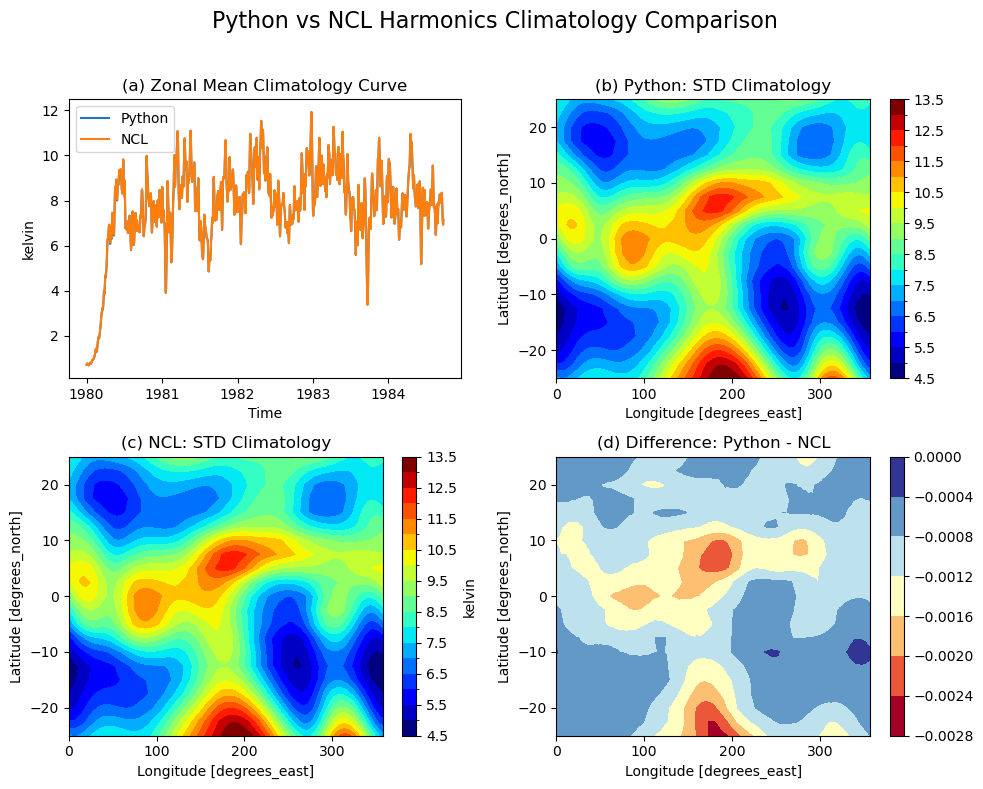

Processing er wave...
<xarray.DataArray (time: 7305, lat: 21, lon: 144)> Size: 88MB
array([[[ 0.85132617,  0.7534063 ,  0.6485504 , ...,  0.9849996 ,
          0.9770897 ,  0.92972445],
        [ 0.2950465 ,  0.30628005,  0.35797566, ...,  0.48789147,
          0.3942347 ,  0.32610416],
        [ 0.19476561,  0.30698615,  0.45867637, ...,  0.24951257,
          0.16211528,  0.14306505],
        ...,
        [-1.7425495 , -1.5657772 , -1.3660761 , ..., -1.8635099 ,
         -1.9165753 , -1.8687471 ],
        [-1.2129345 , -1.2016457 , -1.0870599 , ..., -0.57861364,
         -0.8914755 , -1.1087798 ],
        [ 0.14547978,  0.14774886,  0.18071881, ...,  0.39594486,
          0.2692905 ,  0.18457863]],

       [[ 0.5556461 ,  0.4301341 ,  0.32398456, ...,  0.89972687,
          0.80698794,  0.68675625],
        [ 0.11686134,  0.20215157,  0.3340752 , ...,  0.22960515,
          0.13182129,  0.09206868],
        [ 0.188338  ,  0.41027787,  0.6438138 , ..., -0.07039892,
         -0.0745849

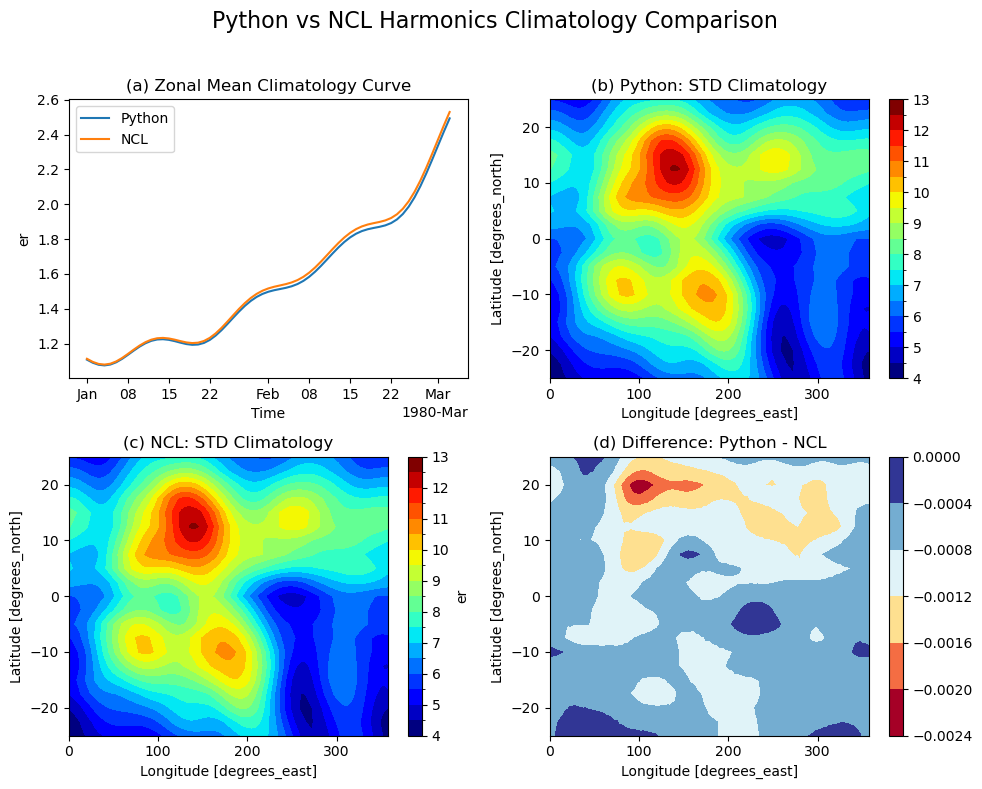

Processing mjo wave...
<xarray.DataArray (time: 7305, lat: 21, lon: 144)> Size: 88MB
array([[[ 0.6891513 ,  0.68007886,  0.6602942 , ...,  0.6576696 ,
          0.67739004,  0.6880696 ],
        [ 0.83600646,  0.82051647,  0.7852157 , ...,  0.7767052 ,
          0.8123568 ,  0.83277106],
        [ 1.2255372 ,  1.1734751 ,  1.090023  , ...,  1.196764  ,
          1.235723  ,  1.2459812 ],
        ...,
        [-0.91409445, -0.62917656, -0.35711777, ..., -1.7804586 ,
         -1.4965575 , -1.2054684 ],
        [-1.6400521 , -1.3772622 , -1.1098303 , ..., -2.344662  ,
         -2.129127  , -1.892513  ],
        [-1.6985809 , -1.5863262 , -1.4540976 , ..., -1.9040754 ,
         -1.8580692 , -1.7894505 ]],

       [[ 0.92602295,  0.92897   ,  0.918812  , ...,  0.84303033,
          0.88248897,  0.9103622 ],
        [ 1.0023971 ,  1.006865  ,  0.9914469 , ...,  0.8851659 ,
          0.93958867,  0.9793801 ],
        [ 1.3062189 ,  1.2881026 ,  1.2387829 , ...,  1.184687  ,
          1.252323

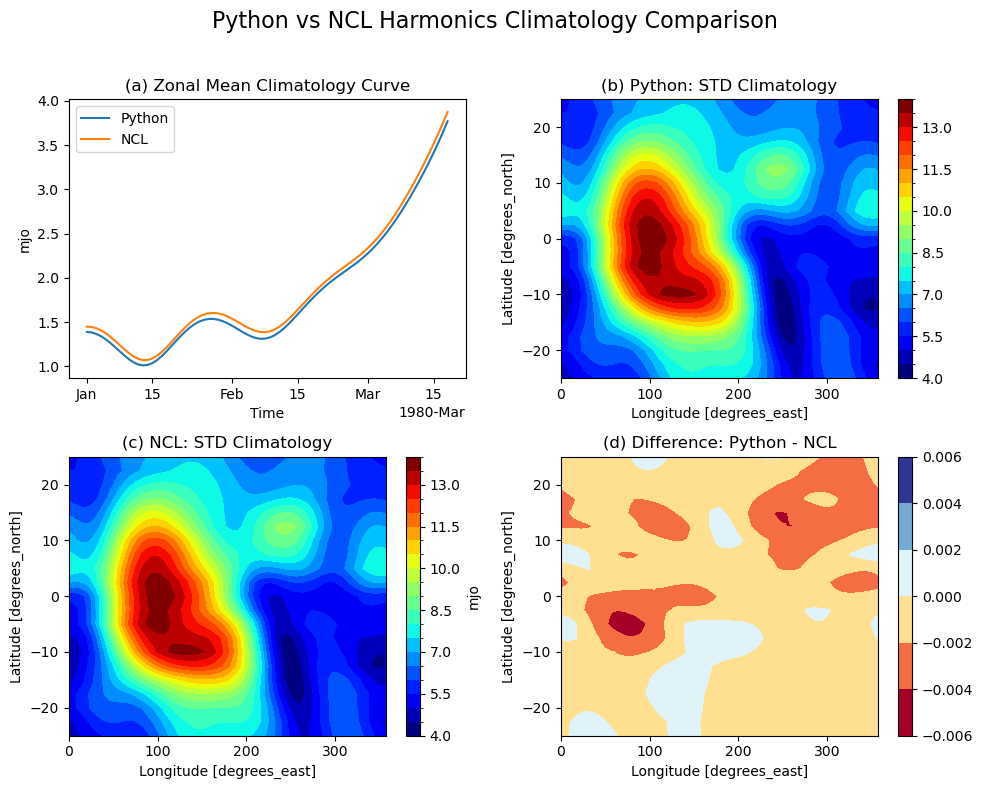

All wave filtering completed!


In [63]:
if __name__ == "__main__":
    ds = xr.open_dataset('I:/olr.day.mean.nc').olr.sel(
        time=slice('1980-01-01', '1999-12-31'),
        lat=slice(25, -25)).sortby('lat')

    # 依次计算Kelvin、ER和MJO波
    wave_types = ['kelvin', 'er', 'mjo']
    filtered_waves = {}
    
    for wave_name in wave_types:
        print(f"Processing {wave_name} wave...")
        filtered_waves[wave_name] = extract_wave_signal_optimized(ds, wave_name=wave_name, obs_per_day=1)
        
        # 检查结果
        check_filter_wave(filtered_waves[wave_name], f"I:/OLR{wave_name}_25.nc", wave_name)
        
    print("All wave filtering completed!")